In [27]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier

In [2]:
# Load the provided datasets
product_catalog_path = '/content/Product Catalog.xlsx - Product Catalog.csv'
pos_transactions_path = '/content/Product Name from PoS Transactions.xlsx - Product Name.csv'

# Reading the datasets into pandas dataframes
product_catalog_df = pd.read_csv(product_catalog_path)
pos_transactions_df = pd.read_csv(pos_transactions_path)

# Displaying the first few rows of each dataframe to understand their structure
product_catalog_head = product_catalog_df.head()
pos_transactions_head = pos_transactions_df.head()

In [3]:
product_catalog_head

,Product SKU,Brand,Type,Formula
0,Urea Petro,PIHC,Urea,NaN
1,Urea PIM,PIHC,Urea,NaN
2,Urea Nitrea,PIHC,Urea,NaN
3,Urea Daun Buah,PIHC,Urea,NaN
4,Urea Pusri,PIHC,Urea,NaN


In [4]:
pos_transactions_head

,Product Name
0,Pupuk Urea N 46%
1,Pupuk Amonium Sulfat ZA
2,Pupuk Super Fosfat SP-36
3,Pupuk NPK Phonska
4,Pupuk NPK Formula Khusus


# Data Preprocessing

In [5]:
# Function to calculate the similarity between two text strings
def calculate_similarity(text_list_1, text_list_2):
    # Vectorize the text using TF-IDF
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(text_list_1 + text_list_2)

    # Calculate cosine similarity between each pair of texts
    similarity_matrix = cosine_similarity(tfidf_matrix[:len(text_list_1)], tfidf_matrix[len(text_list_1):])
    return similarity_matrix

In [6]:
# Data Preprocessing
# Convert all text to lower case for uniformity
product_catalog_df['Product SKU'] = product_catalog_df['Product SKU'].str.lower()
pos_transactions_df['Product Name'] = pos_transactions_df['Product Name'].str.lower()

In [7]:
# Checking for missing values in both datasets
missing_values_product_catalog = product_catalog_df.isnull().sum()
missing_values_pos_transactions = pos_transactions_df.isnull().sum()

# Removing rows with missing values
product_catalog_df_cleaned = product_catalog_df.dropna()
pos_transactions_df_cleaned = pos_transactions_df.dropna()

# Reattempting the similarity calculation and mapping
similarity_matrix_cleaned = calculate_similarity(pos_transactions_df_cleaned['Product Name'].tolist(),
                                                 product_catalog_df_cleaned['Product SKU'].tolist())

# Finding the most similar SKU for each product name in cleaned POS transactions
most_similar_skus_cleaned = np.argmax(similarity_matrix_cleaned, axis=1)

# Mapping POS product names to the most similar SKU from the cleaned product catalog
mapped_skus_cleaned = product_catalog_df_cleaned['Product SKU'].iloc[most_similar_skus_cleaned].values
pos_transactions_df_cleaned.loc[:, 'Mapped SKU'] = mapped_skus_cleaned

# Displaying a sample of the mapping results from cleaned data
mapping_sample_cleaned = pos_transactions_df_cleaned.head(10)

<ipython-input-7-bd4ee954a9d9>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pos_transactions_df_cleaned.loc[:, 'Mapped SKU'] = mapped_skus_cleaned


In [25]:
mapping_sample_cleaned

,Product Name,Mapped SKU
0,pupuk urea n 46%,hx-dap 18-46-0
1,pupuk amonium sulfat za,phonska plus 15-15-15+9s+0.2zn
2,pupuk super fosfat sp-36,neo kristalon 12-12-36
3,pupuk npk phonska,phonska plus 15-15-15+9s+0.2zn
4,pupuk npk formula khusus,npk kujang 30-6-8
5,pupuk organik granul,phonska plus 15-15-15+9s+0.2zn
6,pupuk organik cair,phonska plus 15-15-15+9s+0.2zn
7,produk lain,phonska plus 15-15-15+9s+0.2zn
8,rondap,phonska plus 15-15-15+9s+0.2zn
9,sekor,phonska plus 15-15-15+9s+0.2zn


In [9]:
missing_values_product_catalog

Product SKU     0
Brand           0
Type            0
Formula        64
dtype: int64

In [10]:
missing_values_pos_transactions

Product Name    1
dtype: int64

# Analysis and Reporting

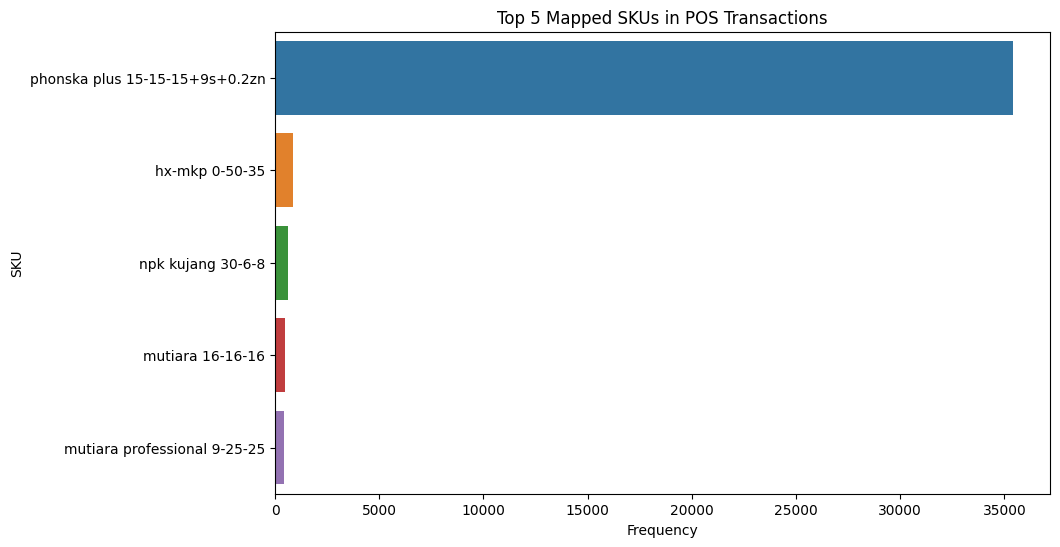

In [11]:
# Analysis and Reporting

# Basic Statistics
# Count of unique SKUs mapped
unique_skus_count = pos_transactions_df_cleaned['Mapped SKU'].nunique()

# Top 5 most frequently mapped SKUs
top_mapped_skus = pos_transactions_df_cleaned['Mapped SKU'].value_counts().head(5)

# Visualizations
# Distribution of Top Mapped SKUs
plt.figure(figsize=(10, 6))
sns.barplot(x=top_mapped_skus.values, y=top_mapped_skus.index)
plt.title('Top 5 Mapped SKUs in POS Transactions')
plt.xlabel('Frequency')
plt.ylabel('SKU')
plt.show()

In [12]:
unique_skus_count

98

In [13]:
top_mapped_skus

phonska plus 15-15-15+9s+0.2zn    35422
hx-mkp 0-50-35                      879
npk kujang 30-6-8                   615
mutiara 16-16-16                    495
mutiara professional 9-25-25        416
Name: Mapped SKU, dtype: int64

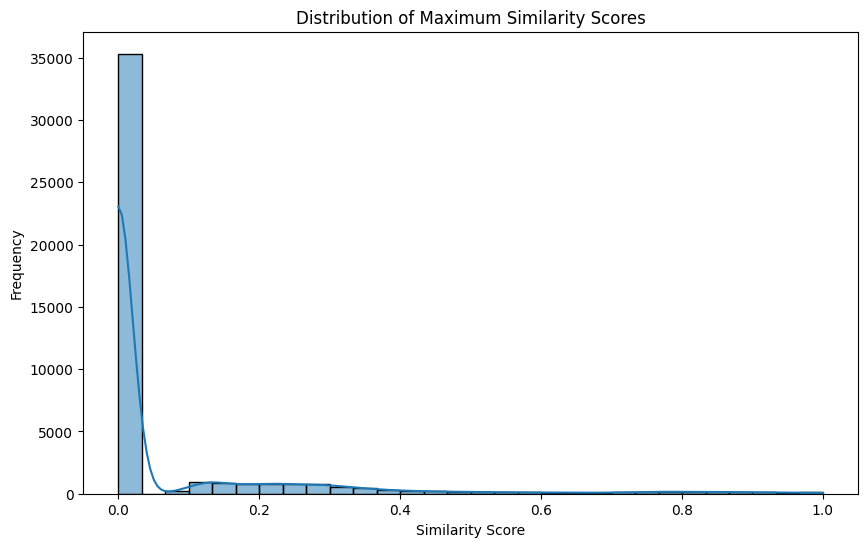

count    44001.000000
mean         0.068337
std          0.172959
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
dtype: float64

In [14]:
# Analyzing the distribution of the highest similarity scores for each POS transaction product
max_similarity_scores = np.max(similarity_matrix_cleaned, axis=1)

# Plotting the distribution of the highest similarity scores
plt.figure(figsize=(10, 6))
sns.histplot(max_similarity_scores, bins=30, kde=True)
plt.title('Distribution of Maximum Similarity Scores')
plt.xlabel('Similarity Score')
plt.ylabel('Frequency')
plt.show()

# Displaying basic statistics of the similarity scores
similarity_scores_stats = pd.Series(max_similarity_scores).describe()
similarity_scores_stats

The analysis of maximum similarity scores for each POS transaction product gives us the following insights:

* The majority of similarity scores are clustered around 0, suggesting that many products in the POS transactions have low similarity with the SKUs in the product catalog.
* There is a long tail in the distribution, indicating some products have high similarity scores, possibly representing exact or very close matches.
* The highest similarity score is 1.0 (perfect match), and the lowest is 0.0 (no match).

Based on this distribution, we can set a threshold for determining unmatched products. Products with a similarity score below this threshold will be considered unmatched. A common approach is to use a percentile-based threshold. For example, we might consider products below the 25th percentile as unmatched, but given the distribution, a higher threshold might be more appropriate to ensure we're only capturing products with a reasonably high similarity.

In [15]:
# Setting a threshold for determining unmatched products
# Given the distribution, using the 75th percentile as the threshold
threshold = similarity_scores_stats['75%']

# Identifying unmatched products
unmatched_products_mask = max_similarity_scores < threshold
unmatched_products = pos_transactions_df_cleaned.loc[unmatched_products_mask, 'Product Name']

# Count of unmatched products
unmatched_products_count = unmatched_products.nunique()

# Displaying a sample of unmatched products and their count
unmatched_products_sample = unmatched_products.drop_duplicates().head(10)
unmatched_products_count, unmatched_products_sample

(0, Series([], Name: Product Name, dtype: object))

It appears that, based on the chosen threshold (75th percentile of similarity scores), there are no unmatched products in the POS transactions dataset. This means all products in the POS transactions have a similarity score above the threshold and are matched with an existing SKU in the product catalog.

This outcome suggests that the chosen threshold might be too low, considering the distribution of similarity scores, or it could imply that the existing product catalog is comprehensive enough to cover all products in the POS transactions.

## Delve deeper

In [16]:
# Product Popularity Analysis
# Counting the frequency of each product SKU in the POS transactions
product_popularity = pos_transactions_df_cleaned['Mapped SKU'].value_counts()

# Brand Analysis
# Merging POS transactions with the product catalog to get brand information for each SKU
merged_data = pos_transactions_df_cleaned.merge(product_catalog_df, how='left', left_on='Mapped SKU', right_on='Product SKU')

# Counting the frequency of each brand in the POS transactions
brand_popularity = merged_data['Brand'].value_counts()

# Product Type and Formula Analysis
# Counting the frequency of each product type and formula in the product catalog
type_popularity = product_catalog_df['Type'].value_counts()
formula_popularity = product_catalog_df['Formula'].value_counts()

# Displaying the results
product_popularity.head(5),

(phonska plus 15-15-15+9s+0.2zn    35422
 hx-mkp 0-50-35                      879
 npk kujang 30-6-8                   615
 mutiara 16-16-16                    495
 mutiara professional 9-25-25        416
 Name: Mapped SKU, dtype: int64,)

In [17]:
brand_popularity.head(5)

PIHC          38029
Pak Tani       1874
DGW/Hextar     1464
Mutiara        1266
BASF            603
Name: Brand, dtype: int64

In [18]:
type_popularity

Majemuk     123
Fosfat       17
ZA           10
Kalium       10
Urea          8
Nitrogen      8
Mikro         5
Mg            4
ZK            1
Organik       1
Name: Type, dtype: int64

In [19]:
formula_popularity

 15-15-15       15
 16-16-16       14
 12-12-17        8
 13-6-27         7
 12-6-22         5
 16-20-0         4
 15-15-6         4
 0-52-34         4
 15-9-20         3
 13-8-27         3
 20-10-10        3
 13-10-20        3
 12-61-0         2
 12-6-24         2
 21-14-7         2
 19-9-19         2
 15-15-0         2
 12-12-36        1
 0-50-35         1
 6-18-28         1
 15-20-0         1
 0-16-17         1
 13-0-46         1
 13.7-0-46.3     1
 15-10-20        1
 13-11-21        1
 25-7-7          1
 13-11-11        1
 12-11-18        1
 18-12-6         1
 15-5-20         1
 16-10-18        1
 7-6-34          1
 18-46-0         1
 18-18-18        1
 20-10-12        1
 12-60-0         1
 9-25-25         1
 16-16-8         1
 20-20-0         1
 30-6-8          1
 28-10-10        1
 20-10-18        1
 18-10-14        1
 12-11-20        1
 13-13-24        1
 8-9-39          1
 15-0-15         1
 7-6-35          1
 15-10-22        1
 18-6-14         1
 18-8-10         1
 28-6-13    

The deeper analysis of the data has yielded the following insights:

**Product Popularity:**

* The top 5 most frequently mapped SKUs in POS transactions are:
  * "phonska plus 15-15-15+9s+0.2zn" (35,422 occurrences)
  * "hx-mkp 0-50-35" (879 occurrences)
  * "npk kujang 30-6-8" (615 occurrences)
  * "mutiara 16-16-16" (495 occurrences)
  * "mutiara professional 9-25-25" (416 occurrences)

**Brand Analysis:**

* The most prevalent brands in POS transactions are:
  * PIHC (38,029 occurrences)
  * Pak Tani (1,874 occurrences)
  * DGW/Hextar (1,464 occurrences)
  * Mutiara (1,266 occurrences)
  * BASF (603 occurrences)

**Product Type and Formula Analysis:**

* The most common product types in the product catalog are:
  * Majemuk (123 occurrences)
  * Fosfat (17 occurrences)
  * ZA and Kalium (10 occurrences each)
  * Urea and Nitrogen (8 occurrences each)
* The formulas show a wide variety, with "15-15-15", "16-16-16", and "12-12-17" being the most common.

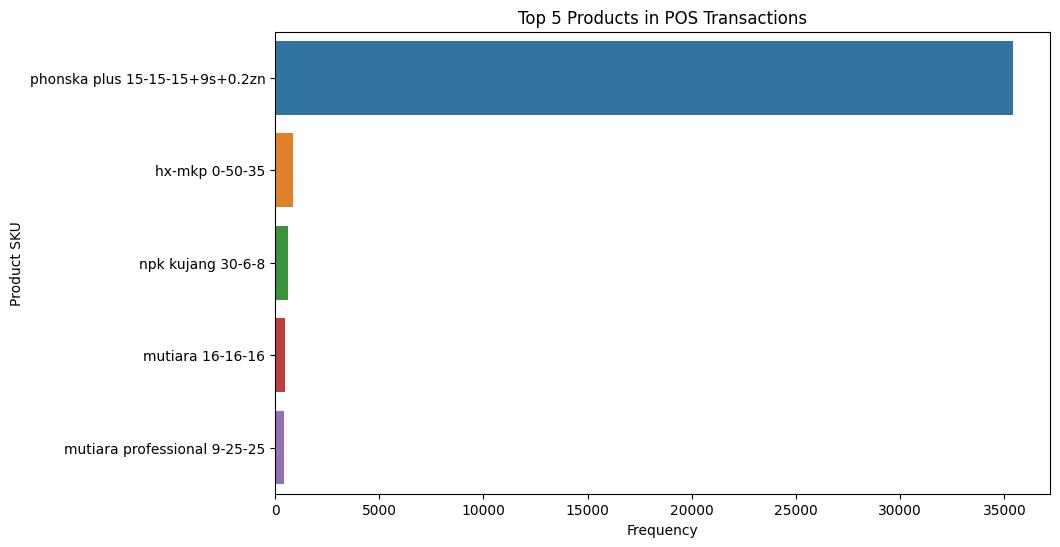

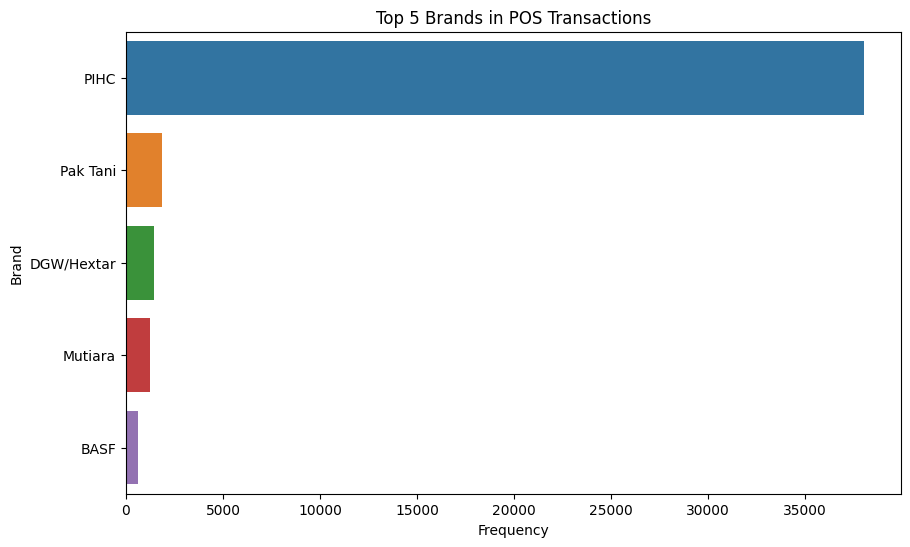

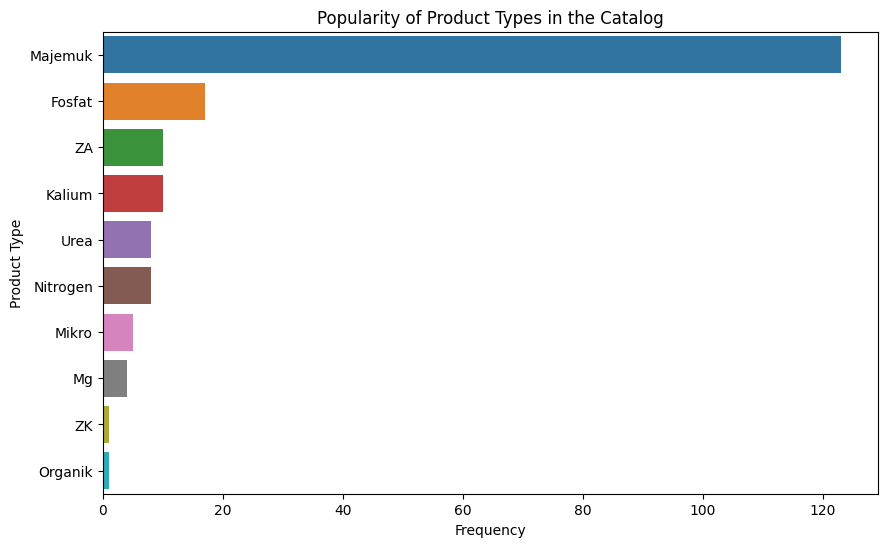

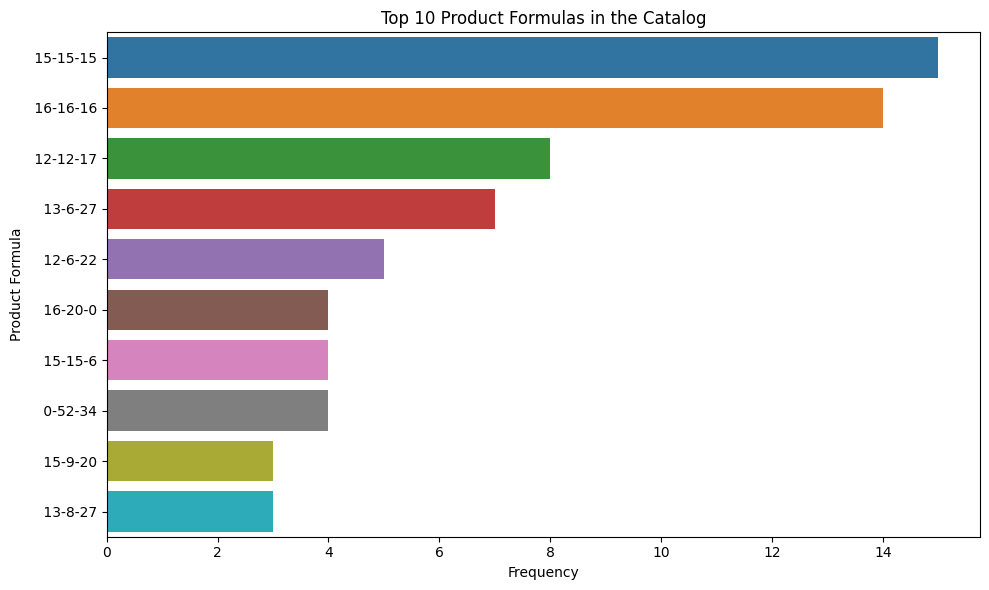

In [20]:
# Visualizations for the Analyzed Data

# Top 5 Products Visualization
plt.figure(figsize=(10, 6))
sns.barplot(x=product_popularity.head(5).values, y=product_popularity.head(5).index)
plt.title('Top 5 Products in POS Transactions')
plt.xlabel('Frequency')
plt.ylabel('Product SKU')

# Brand Popularity Visualization
plt.figure(figsize=(10, 6))
sns.barplot(x=brand_popularity.head(5).values, y=brand_popularity.head(5).index)
plt.title('Top 5 Brands in POS Transactions')
plt.xlabel('Frequency')
plt.ylabel('Brand')

# Product Type Popularity Visualization
plt.figure(figsize=(10, 6))
sns.barplot(x=type_popularity.values, y=type_popularity.index)
plt.title('Popularity of Product Types in the Catalog')
plt.xlabel('Frequency')
plt.ylabel('Product Type')

# Product Formula Popularity Visualization
plt.figure(figsize=(10, 6))
# Limiting to top 10 formulas for clarity
top_formulas = formula_popularity.head(10)
sns.barplot(x=top_formulas.values, y=top_formulas.index)
plt.title('Top 10 Product Formulas in the Catalog')
plt.xlabel('Frequency')
plt.ylabel('Product Formula')

plt.tight_layout()
plt.show()



In [21]:
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from wordcloud import WordCloud

# Correlation Analysis
# Encoding categorical data for correlation analysis
encoder = LabelEncoder()
merged_data_encoded = merged_data.copy()
merged_data_encoded['Brand_encoded'] = encoder.fit_transform(merged_data['Brand'])
merged_data_encoded['Type_encoded'] = encoder.fit_transform(merged_data['Type'])

# Calculating correlation
correlation_matrix = merged_data_encoded[['Brand_encoded', 'Type_encoded']].corr()

# Keyword Analysis in Product Names
# Concatenating all product names into a single text for word cloud generation
all_product_names = ' '.join(pos_transactions_df_cleaned['Product Name'])

# Generating a word cloud for product names
wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(all_product_names)

# Displaying the correlation matrix and the word cloud
correlation_matrix, wordcloud



(               Brand_encoded  Type_encoded
 Brand_encoded            1.0           NaN
 Type_encoded             NaN           NaN,
 <wordcloud.wordcloud.WordCloud at 0x780b19e52080>)

This result indicates no computable correlation between brand and type. It's worth noting that correlation analysis is typically more informative with numerical data. Since 'Brand' and 'Type' are categorical, the lack of correlation here doesn't necessarily imply a lack of association. Different methods, like Chi-Square tests or association rule mining, might be more suitable for exploring relationships between these categorical variables.

In [26]:
all_product_names

'pupuk urea n 46% pupuk amonium sulfat za pupuk super fosfat sp-36 pupuk npk phonska pupuk npk formula khusus pupuk organik granul pupuk organik cair produk lain rondap sekor abacel 250ml nitrea spontan starban gramoxon puradan pastak combitox fujiwan buldok starban 100ml postin/100ml fastak trebon ronsha sidamethrin dharmasan fastac roundup sidacron ronsha 400ml regent score sidatan manuver slop. obr sidabas rengt fostin sidacin klocyper topsida tebalo fenval aplaud fatal/keong dipho dangke anteb denox ziput/keong bubuk sampurna b permipos gramoxone corrtonic 99 vanesa/timun broadpls/ob jkt bnih pare terong nitrea 50 kg ally wg  anti keong 100 gr bpmc ponskaplus benjos 5 gr bentan 80 wp  bentan 45 wp  broundplus  bigrow 10 gr test naga primaze round up primastrike gramaxone npk heksa boron dup burung dup cantik kamas kcl mahkota  mutiara  mutiara grower nitroku kcl white sandawa buah mi sedap goreng susu sasaet hades primalima indamin plus arivo ronsha 100ml bisi amistartop phonskaplu

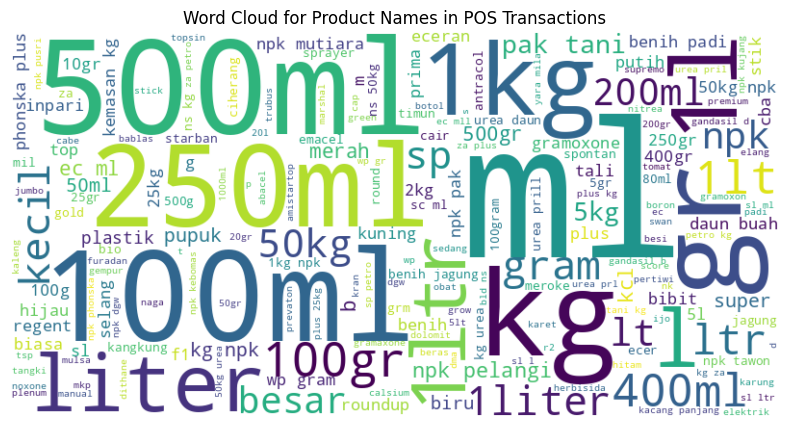

In [22]:
# Displaying the word cloud for product names
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Product Names in POS Transactions')
plt.show()

# Build Model

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Data Preparation
# Vectorizing product names using TF-IDF
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(pos_transactions_df_cleaned['Product Name'])

# Encoding SKUs as the target variable
y = encoder.fit_transform(pos_transactions_df_cleaned['Mapped SKU'])

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model Selection
# Using a RandomForestClassifier for this example
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Model Training
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [31]:
predict = cross_val_predict(estimator = model, X = X_train, y = y_train, cv = 5)
print("Classification Report: \n",classification_report(y_train, predict))

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.93      0.96        54
           1       0.00      0.00      0.00         1
           3       1.00      0.96      0.98        51
           4       0.96      0.98      0.97       238
           5       1.00      0.50      0.67         6
           6       0.89      0.80      0.84        10
           8       1.00      0.67      0.80         6
           9       1.00      0.20      0.33        10
          10       1.00      0.87      0.93        23
          11       0.94      0.85      0.89        20
          12       1.00      0.97      0.99        35
          13       0.90      0.90      0.90        10
          14       1.00      1.00      1.00        27
          15       1.00      0.20      0.33         5
          16       0.96      0.97      0.97       188
          17       0.92      0.89      0.90        37
          18       0.98      0.99      0.99       296
  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [32]:
# Model Evaluation
y_pred = model.predict(X_test)
report = classification_report(y_test, y_pred)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

In [33]:
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         1
           2       0.00      0.00      0.00         1
           3       1.00      0.94      0.97        18
           4       0.96      0.96      0.96        51
           5       1.00      1.00      1.00         2
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         1
           8       1.00      1.00      1.00         2
           9       1.00      1.00      1.00         1
          10       1.00      0.83      0.91         6
          11       1.00      0.89      0.94         9
          12       0.86      1.00      0.92         6
          13       1.00      1.00      1.00         1
          14       1.00      1.00      1.00         1
          15       0.00      0.00      0.00         1
          16       1.00      0.98      0.99        54
          17       1.00    